<a href="https://colab.research.google.com/github/nthammadi-uncc/MultiEffects_AirPollutants/blob/main/Notebooks/Multi_Effects_Model_for_Electricity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-effects Model of Sustainable and Non-Sustainable Electricity Usage and its impact on Carbon Emissions across the US

#### Install libraries

In [1]:
#run both R and python 
%load_ext rpy2.ipython

##### Install packages

In [2]:
#mount google drive to load pre installs and zipped libraries
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#extract library zip file from location - https://drive.google.com/drive/folders/1z3tM37Cf7zr3hXF5EtPMRnMwdoEb6arm
%cp drive/MyDrive/R_libraries/library.tar.gz .

In [4]:
!du -sh library.tar.gz

701M	library.tar.gz


In [5]:
#copy library to current directory
!tar xf library.tar.gz

tar: Removing leading `/' from member names


In [6]:
%ls usr/local/lib/R/site-library/

abind/           emmeans/       HDInterval/   parallelly/     shinystan/
arrayhelpers/    estimability/  htmlwidgets/  patchwork/      shinythemes/
bayesplot/       fontawesome/   httpuv/       pbdZMQ/         sourcetools/
BH/              furrr/         igraph/       plyr/           StanHeaders/
bridgesampling/  future/        inline/       polyclip/       svUnit/
brms/            ggdag/         IRdisplay/    posterior/      tensorA/
Brobdingnag/     ggdist/        IRkernel/     promises/       threejs/
broom/           ggforce/       later/        RcppArmadillo/  tidybayes/
broom.mixed/     ggh4x/         lazyeval/     RcppEigen/      tidygraph/
checkmate/       ggokabeito/    listenv/      RcppParallel/   tweenr/
coda/            ggraph/        loo/          repr/           V8/
colourpicker/    ggrepel/       markdown/     reshape2/       viridis/
crosstalk/       ggridges/      matrixStats/  rstan/          xtable/
dagitty/         globals/       miniUI/       rstantools/     xts/


In [7]:
%%R
.libPaths('usr/local/lib/R/site-library/')

In [8]:
%%R
.libPaths()

[1] "/content/usr/local/lib/R/site-library"
[2] "/usr/local/lib/R/site-library"        
[3] "/usr/lib/R/site-library"              
[4] "/usr/lib/R/library"                   


##### Load packages

In [9]:
%%R
library(readr)
library(dplyr)
library(tidyverse)
library(magrittr)

library(dagitty)
library(ggdag)
library(ggplot2)

library(brms)
library(tidybayes)

library(broom)        # Convert model objects to data frames
library(broom.mixed)  # Convert brms model objects to data frames
library(emmeans)      # Calculate marginal effects in even fancier ways
library(ggh4x)        # For nested facets in ggplot
library(ggrepel)      # For nice non-overlapping labels in ggplot
library(ggdist)       # For distribution-related ggplot geoms
library(scales)       # For formatting numbers with comma(), dollar(), etc.
library(patchwork)    # For combining plots
library(ggokabeito)   # Colorblind-friendly color palette

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:purrr’:

    set_names


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: 
Attaching package: ‘ggdag’


R[write to console]: The following obj

In [10]:
#load font
!wget "https://fonts.google.com/download?family=Barlow%20Semi%20Condensed"
!unzip "download?family=Barlow Semi Condensed"
#!mv BarlowSemiCondensed-Regular.ttf /usr/share/fonts/truetype/

!fc-cache -f -v

--2022-04-11 05:47:30--  https://fonts.google.com/download?family=Barlow%20Semi%20Condensed
Resolving fonts.google.com (fonts.google.com)... 142.251.6.113, 142.251.6.139, 142.251.6.138, ...
Connecting to fonts.google.com (fonts.google.com)|142.251.6.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘download?family=Barlow Semi Condensed’

download?family=Bar     [ <=>                ] 915.13K  --.-KB/s    in 0.05s   

2022-04-11 05:47:30 (17.0 MB/s) - ‘download?family=Barlow Semi Condensed’ saved [937092]

Archive:  download?family=Barlow Semi Condensed
  inflating: OFL.txt                 
  inflating: BarlowSemiCondensed-Thin.ttf  
  inflating: BarlowSemiCondensed-ThinItalic.ttf  
  inflating: BarlowSemiCondensed-ExtraLight.ttf  
  inflating: BarlowSemiCondensed-ExtraLightItalic.ttf  
  inflating: BarlowSemiCondensed-Light.ttf  
  inflating: BarlowSemiCondensed-LightItalic.ttf  
  inflating: BarlowSemiCondensed-Regu

In [11]:
%%R
# Custom ggplot theme to make pretty plots
# Get Barlow Semi Condensed at https://fonts.google.com/specimen/Barlow+Semi+Condensed
theme_clean <- function() {
  theme_minimal(base_family = "Barlow Semi Condensed") +
    theme(panel.grid.minor = element_blank(),
          plot.background = element_rect(fill = "white", color = NA),
          plot.title = element_text(face = "bold"),
          axis.title = element_text(face = "bold"),
          strip.text = element_text(face = "bold", size = rel(0.8), hjust = 0),
          strip.background = element_rect(fill = "grey80", color = NA),
          legend.title = element_text(face = "bold"))
}

# Make labels use Barlow by default
update_geom_defaults("label_repel", 
                     list(family = "Barlow Semi Condensed",
                          fontface = "bold"))
update_geom_defaults("label", 
                     list(family = "Barlow Semi Condensed",
                          fontface = "bold"))

#### Set seed and any constant variables

In [12]:
%%R
# Make all the random draws reproducible
set.seed(1234)

options(mc.cores = 4,  # Use 4 cores
        brms.backend = "cmdstanr")
bayes_seed <- 1234

#### R version

In [13]:
%%R
R.version.string

[1] "R version 4.1.3 (2022-03-10)"


#### Load Data from Github

In [14]:
%%R
#set up data urls from github
data_url <- "https://raw.githubusercontent.com/nthammadi-uncc/MultiEffects_AirPollutants/main/clean_data/electricity_analysis.csv"
#read data
electricity_df <- read_csv(url(data_url))

R[write to console]: New names:
* `` -> ...1



Rows: 102 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): STATE, STATE.NAME, REGION, DIVISION, RULING.PARTY, ENERGY.SOURCE
dbl (4): ...1, GENERATION_MM.MWh, CONSUMPTION_MM.MWh, CO2.EMISSION_MM.METRIC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [15]:
#convert R dataframe to python dataframe
%R -o electricity_df
from IPython.display import display, HTML

display(HTML(electricity_df.to_html()))

,...1,STATE,STATE.NAME,REGION,DIVISION,RULING.PARTY,ENERGY.SOURCE,GENERATION_MM.MWh,CONSUMPTION_MM.MWh,CO2.EMISSION_MM.METRIC.TONS
1,1.0,AK,Alaska,West,Pacific,REPUBLICAN,Not Sustainable,0.1423,0.1112,2.2050
2,2.0,AK,Alaska,West,Pacific,REPUBLICAN,Sustainable,0.3810,14.3088,1.2539
3,3.0,AL,Alabama,South,East South Central,REPUBLICAN,Not Sustainable,2.0843,2.2403,21.1638
4,4.0,AL,Alabama,South,East South Central,REPUBLICAN,Sustainable,9.3776,242.0182,23.6394
5,5.0,AR,Arkansas,South,West South Central,REPUBLICAN,Not Sustainable,1.3599,1.7340,15.5566
6,6.0,AR,Arkansas,South,West South Central,REPUBLICAN,Sustainable,3.1931,81.2342,7.8969
7,7.0,AZ,Arizona,West,Mountain,DEMOCRAT,Not Sustainable,1.1657,1.5584,14.4691
8,8.0,AZ,Arizona,West,Mountain,DEMOCRAT,Sustainable,7.9433,240.8628,21.2452
9,9.0,CA,California,West,Pacific,DEMOCRAT,Not Sustainable,0.4081,0.0109,1.2938
10,10.0,CA,California,West,Pacific,DEMOCRAT,Sustainable,15.6236,413.4512,41.8743


In [16]:
%%R
summary(electricity_df)

      ...1           STATE            STATE.NAME           REGION         
 Min.   :  1.00   Length:102         Length:102         Length:102        
 1st Qu.: 26.25   Class :character   Class :character   Class :character  
 Median : 51.50   Mode  :character   Mode  :character   Mode  :character  
 Mean   : 51.50                                                           
 3rd Qu.: 76.75                                                           
 Max.   :102.00                                                           
   DIVISION         RULING.PARTY       ENERGY.SOURCE      GENERATION_MM.MWh
 Length:102         Length:102         Length:102         Min.   : 0.0000  
 Class :character   Class :character   Class :character   1st Qu.: 0.5374  
 Mode  :character   Mode  :character   Mode  :character   Median : 1.6229  
                                                          Mean   : 3.2634  
                                                          3rd Qu.: 3.8966  
                   

#### Directed Acyclic Graph (DAG)

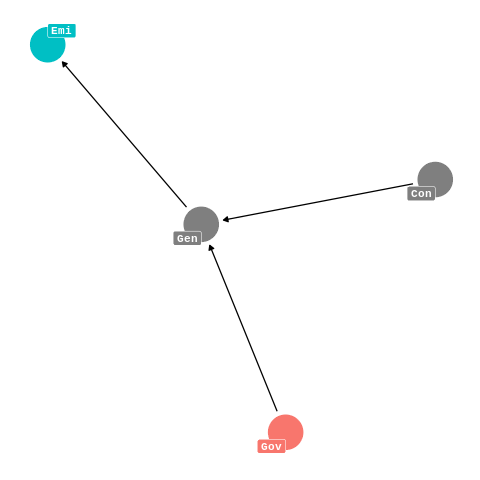

In [17]:
%%R
#Con is for Electricity Consumption
#Gen is for Electricity Generation
#Emi is for Carbon Emissions
#Gov is the ruling party

g <- dagitty('dag {
bb="-3.031,-2.369,3.222,3.541"
Con [pos="1.474,0.389"]
Emi [outcome,pos="-1.111,1.565"]
Gen [pos="-0.087,-0.002"]
Gov [exposure,pos="0.476,-1.816"]
Con -> Gen
Gen -> Emi
Gov -> Gen
}'
)
ggdag::ggdag_status(g, text = FALSE, use_labels = "name") +
  guides(color = "none") +  # Turn off legend
  theme_dag()

#### Prior Predictive

In [ ]:
%%R 
#looking at the original data, we can create a prior predictive with synthetic data